In [2]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os

In [3]:
datagen = N2V_DataGenerator()
image = datagen.load_imgs_from_directory(directory="domes/", filter='*raw.tif', dims='ZYX')

In [4]:
# Since the image is a 3d stack, we will append all the 2d images into a list, 
# delete the first element and create it as a numpy array
print(image[0][0].shape)
print(len(image[0][0]))
image2d_append = []
for i in image[0][0]:
    image2d_append.append(i)
del image2d_append[0]
image2d_append = np.array(image2d_append)

(161, 2048, 2048, 1)
161


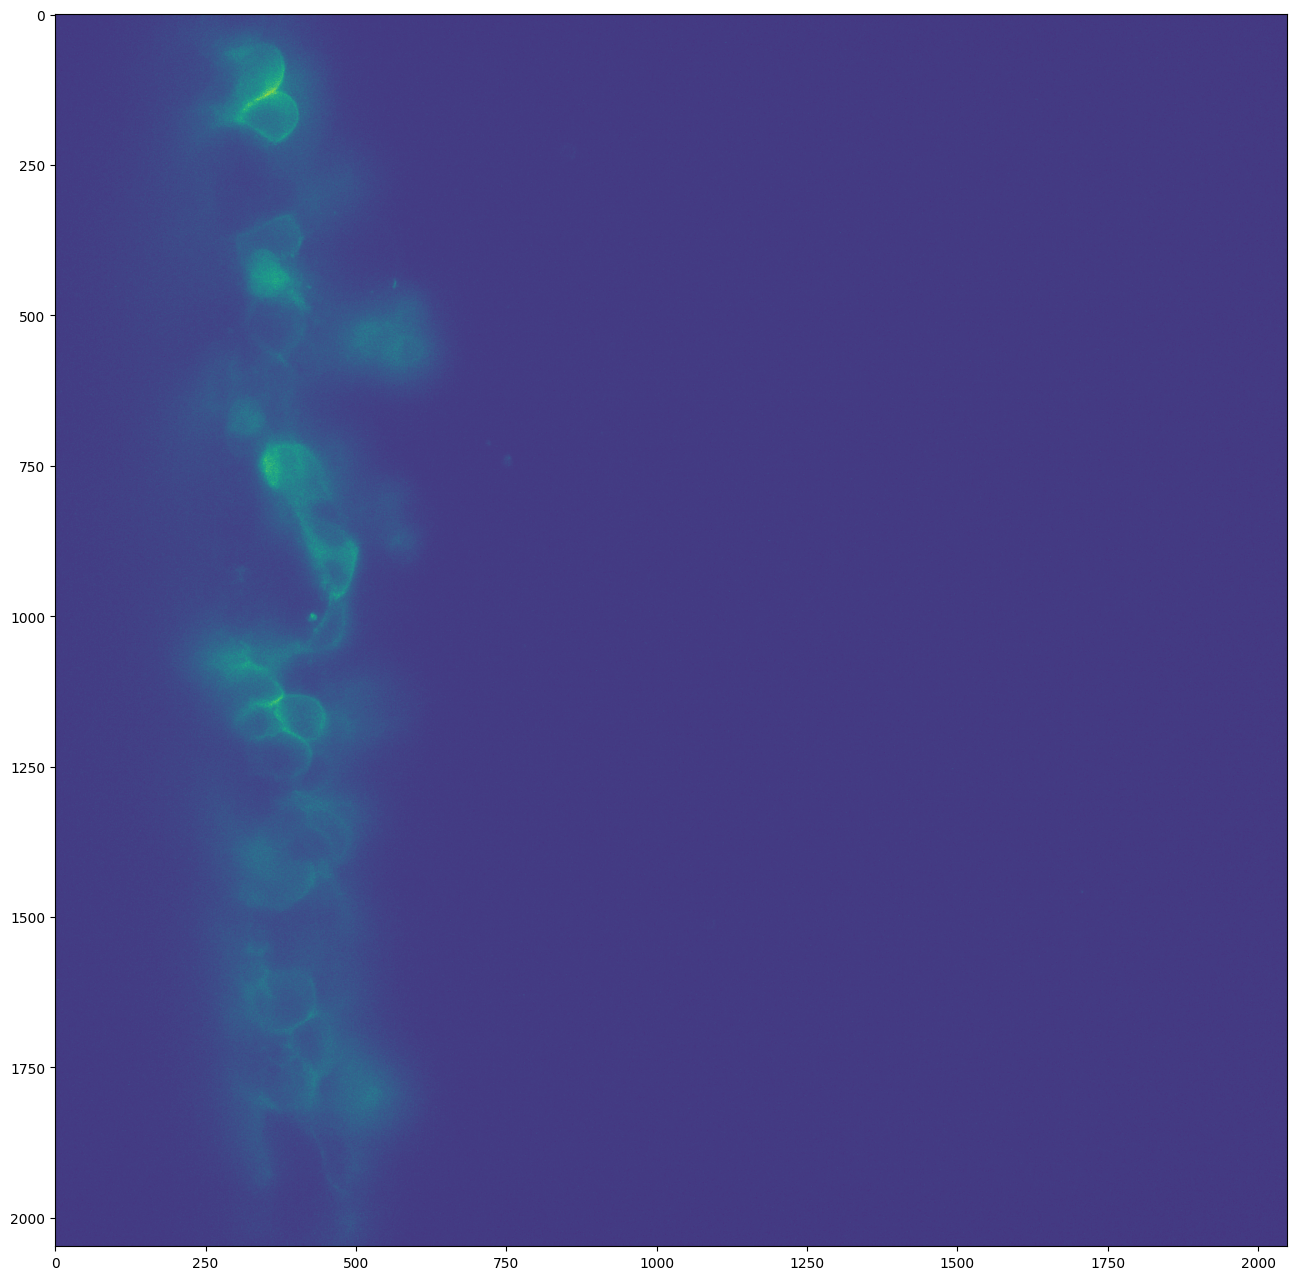

In [5]:
plt.figure(figsize=(32,16))
plt.imshow(image2d_append[0])
plt.show()

In [6]:
# Generate the patches in function of the patch shape. In this case, foreach image we will have 256 non overlaping images
# (*8 ??)
patch_shape = (128,128)
patches = datagen.generate_patches(image2d_append, shape=patch_shape)

Generated patches: (327680, 128, 128, 1)


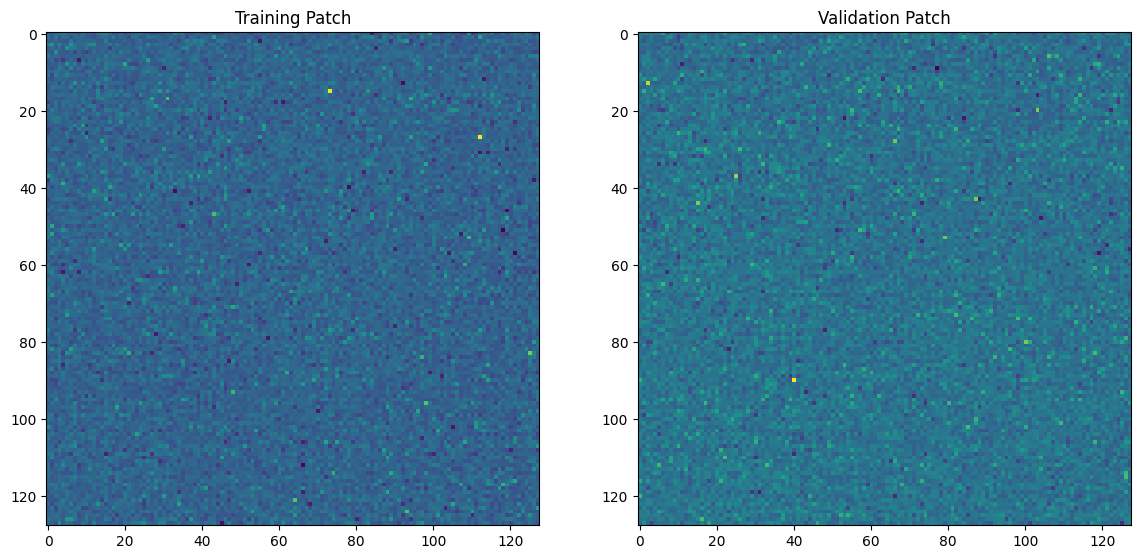

In [7]:
# training is 0.9 of the total patches
X = patches[:294912]
X_val = patches[294912:]
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

In [8]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/2048), train_epochs=25, train_loss='mse', 
                   batch_norm=True, train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(128, 128), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['113.4579'],
 'stds': ['24.362682'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 25,
 'train_steps_per_epoch': 144,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (128, 128),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [9]:
# a name used to identify the model --> change this to something sensible!
model_name = 'dome103_raw2d'
# the base directory in which our model will live
basedir = 'n2v_models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

d:\Python_vscode\venv_tf\Lib\site-packages\n2v\models\n2v_standard.py:429: UserWarning: output path for model already exists, files may be overwritten: D:\Python_vscode\n2v_models\dome103_raw2d
  warnings.warn(


In [10]:
history = model.train(X, X_val)

32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|██████████| 32768/32768 [00:45<00:00, 720.81it/s]


Epoch 1/25
 78/144 [===============>..............] - ETA: 43:54 - loss: 0.2161 - n2v_mse: 0.2161 - n2v_abs: 0.2325

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [ ]:
model.export_TF(name='Noise2Void - 2D Dome 103 raw', 
                description='This is the 2D Noise2Void trained in Dome 103 Raw.', 
                authors=["Pau"],
                test_img=X_val[0], axes='YXC',
                patch_shape=patch_shape)